## Import

In [1]:
import os, sys, inspect, time

import numpy as np
import torch 
import matplotlib.pyplot as plt
torch.multiprocessing.set_sharing_strategy('file_system')

import discrepancy, visualization
from algorithms import ABC_algorithms, TPABC, SMCABC, SMC2ABC, SNLABC, SNL2ABC
import distributions 
import scipy.stats as stats

import utils_os, utils_math

%load_ext autoreload
%autoreload 2

## Problem Definition

In [55]:
from problems.ABC_problems import ABC_Problem

class Gauss_Problem(ABC_Problem): #problem from Fig.4A in PLoS CB Copula paper
    
    def __init__(self, N=100, n=100):
        
        self.N = N # number of posterior samples
        self.n = n # length of the data vector x = {x_1, ..., x_n}
        self.D = 5 # dimensionality of data samples
#         self.d = 5 # dims of sufficient statistics? d=2K? This argument is just not used anywhere... great
        self.prior_args = np.array([[0,1]]) # these are bounds on theta (on X in our case: [0,1])
        
        self.K = 1 # number of thetas
        self.stat = 'raw' # raw means that sufficient statistics is unknown (I guess). y_obs = data_obs
        
#         self.data_obs = self.y_obs #important that first dim=N & y_dim = product of these dims
        
        self.is_batch_sampling_supported = False # (unfinished feature, so keep False for now) speed up rejection sampling
    
    def get_true_theta(self):
        pass # does not matter, as the result goes into 'statistics', where theta is currently not used

    def sample_from_prior(self,size=1):
        return np.random.rand(size)
    
    def simulator(self, theta):
        rho = -0.1 + (0.999+0.1)*theta #problem from Fig.4A in PLoS CB Copula paper, linearly changing rho
        samples = np.zeros((theta.size,self.n,self.D))
        for i,r in enumerate(rho):
            samples[i] = np.random.multivariate_normal(np.zeros(self.D),np.ones((self.D,self.D))*r +\
                                                np.eye(self.D)*(1-r),size=self.n)
        return samples.reshape((-1,self.D)) # [number of theta samples (normally 1) x self.n] x self.D

    # B. correlation between latent
    def _ss_corr(self, Z):
        V = np.mat(Z).T * np.mat(Z) / Z.shape[0]
        (d,d) = V.shape
        upper_tri_elements = V[np.triu_indices(d, k=1)]
        stat = np.array(upper_tri_elements)
        return stat
    
    def statistics(self, data, theta=None):
        if self.stat == 'raw':
            # (correlation) as summary statistics (all margianls are N(0,1) here, don't matter)
            stat = self._ss_corr(data)
            return stat
        else:
            raise NotImplementedError('No ground truth statistics')

In [56]:
DIR = 'results/Gauss'

problem = Gauss_Problem()
theta = problem.sample_from_prior(size=20) # sample some thetas
problem.data_obs = problem.simulator(theta) # generate 'true' observations

In [59]:
### Sequential Neural Likelihood + 
hyperparams = ABC_algorithms.Hyperparams()
hyperparams.save_dir = DIR
hyperparams.device = 'cuda:0'
hyperparams.num_sim = 1000                        # number of simulations
hyperparams.L = 5                                # number of learning rounds
hyperparams.hidden_ratio = 0.1                   # dimensionality of S(x)
hyperparams.type = 'plain'                       # the network architecture of S(x), use CNN here
hyperparams.estimator = 'DV'                    # MI estimator; JSD or DC, see the paper
hyperparams.nde = 'MAF'                          # nde; MAF (D>1) or MDN (D=1)

snl2_abc = SNL2ABC.SNL2_ABC(problem, discrepancy=discrepancy.eculidean_dist, hyperparams=hyperparams)


In [60]:
snl2_abc.run()


iteration  0
# of cpus =  4
[ABC] sub-process start![ABC] sub-process start![ABC] sub-process start![ABC] sub-process start!



[sampling] finished sampling  10
[sampling] finished sampling  20
[sampling] finished sampling  30
[sampling] finished sampling  40

 > fitting encoder
summary statistic dim = 1 original dim = 10
architecture [10, 100, 100, 1]
validation size= 0.8
finished: t= 0 loss= 4.195095971226692e-05 loss val= -1.706508919596672e-05 time= 0.06907486915588379
finished: t= 50 loss= -0.01616152562201023 loss val= -0.01970156468451023 time= 0.054346561431884766
finished: t= 100 loss= -0.07106854766607285 loss val= -0.08608989417552948 time= 0.05495452880859375
finished: t= 150 loss= -0.2636827230453491 loss val= -0.30058664083480835 time= 0.057027339935302734
finished: t= 200 loss= -0.5412391424179077 loss val= -0.563347339630127 time= 0.05741763114929199
finished: t= 250 loss= -0.7460415959358215 loss val= -0.7249103784561157 time= 0.055783748626708984
finished: t= 300 loss

RuntimeError: ZeroDivisionError

In [36]:
# theta = snl2_abc.problem.sample_from_prior(size=20000)
# net = snl2_abc.nde_net
# y_obs, theta = snl2_abc.convert_stat(snl2_abc.whiten(snl2_abc.y_obs)), theta
# # y_obs = np.repeat(y_obs,400,axis=0)
# print(y_obs.shape)
# y_obs, theta = torch.tensor(y_obs).float(), torch.tensor(theta).float().view(1, -1)
# log_probs = net.log_probs(inputs=y_obs, cond_inputs=theta)

(array([  7.,  28.,  59., 155., 211., 228., 182.,  88.,  31.,  11.]),
 array([0.23878428, 0.29068191, 0.34257953, 0.39447716, 0.44637478,
        0.4982724 , 0.55017003, 0.60206765, 0.65396528, 0.7058629 ,
        0.75776052]),
 <a list of 10 Patch objects>)

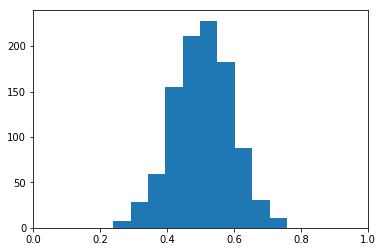

In [39]:
# let us check that the prior did not collapse 
theta = np.empty(1000)
for i in range(len(theta)): 
    theta[i] = snl2_abc.prior()
plt.xlim([0,1])
plt.hist(theta)

In [45]:
# calculate MI using all generated subsamples
all_stats = torch.tensor(np.vstack(snl2_abc.all_stats[0:snl2_abc.l+1])).float()
all_samples = torch.tensor(np.vstack(snl2_abc.all_samples[0:snl2_abc.l+1])).float()
print(all_samples.shape)
snl2_abc.vae_net.MI(all_stats,all_samples,n=100) # n here is the number of shuffles

torch.Size([1000, 1])


tensor(0.7814, grad_fn=<SubBackward0>)

In [47]:
# calculate MI using the last generated subsamples
all_stats = torch.tensor(np.vstack(snl2_abc.all_stats[snl2_abc.l:snl2_abc.l+1])).float()
all_samples = torch.tensor(np.vstack(snl2_abc.all_samples[snl2_abc.l:snl2_abc.l+1])).float()
print(all_samples.shape)
snl2_abc.vae_net.MI(all_stats,all_samples,n=100) # n here is the number of shuffles

torch.Size([200, 1])


tensor(0.4016, grad_fn=<SubBackward0>)

In [41]:
# see Fig.4A in PLoS CB paper for correct answers. Should be roughly 1 bit for 10 dims (D), 0.7 dim for 5 dims
# so far looks alright! 